In [1]:
# import aljabr
from linop import dottest, fwadjtest
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
sys.path.append('/home/plcristille/dev/utils')
import plot
from plot import load_dataset_SYNTHETIC_NOISY, load_unmixed_dataset_SYNTHETIC, plot_sampled_images, plot_spec, norm_hypercube, return_mixture, noise_data_for_snr, add_poisson_noise

main_path = "/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case"
# data_path = "/home/dpineau/Bureau/data/mycube"
data_path = main_path + "/data"
output_path = main_path + "/output"

os.chdir(main_path)
from data_retrieval import inputs_for_models, abundance_maps_inputs
from criteria_definitions import QuadCriterion2, optimal_res_dicho_quad2, mu_instru, SemiQuad_Criterion_Fusion, optimal_res_dicho_semiquad2
import plot_tools
import noise_data
from reco_quality_metrics import Maps_Quality_Metrics_2
from save_and_load import Saver
from instrument_models import Spectro_Model_3, Mirim_Model_For_Fusion
from scipy.stats import entropy
import torch
from skimage import metrics
import pandas as pd

sys.path.append('/home/plcristille/dev/JWST/Hubble')
from noise_functions import make_poisson_bandwise, make_image_with_snr_gaussian

In [2]:

def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))


def pan_img(img):
    img_pan = img
    weights = np.ones((img_pan.shape[0], 1, 1)) / np.float32(img_pan.shape[0])
    return np.sum(weights * img_pan, axis=0)

def calculate_ssim(img1, img2):
    img1_pan = norm_hypercube(pan_img(img1))
    img2_pan = norm_hypercube(pan_img(img2))

    if img1_pan.shape[0]%2!=1:
        img1_pan_shape = img1_pan.shape[0]-1
    else:
        img1_pan_shape = img1_pan.shape[0]
    ssim_index, _ = metrics.structural_similarity(img1_pan, img2_pan, full=True, data_range=1.0, win_size=img1_pan_shape)

    return ssim_index

def return_RMSE(GT, mixture):
    return np.sqrt(np.mean((GT - mixture) ** 2))

def compute_sam(pred, target):
    """
    Computes the Spectral Angle Mapper (SAM) between two inputs.

    Args:
        pred (numpy.ndarray or torch.Tensor): Predicted input of shape (C, H, W) or (C,).
        target (numpy.ndarray or torch.Tensor): Ground truth input of shape (C, H, W) or (C,).
        
    Returns:
        torch.Tensor: SAM in radians. If input is 3D, returns a 2D tensor (H, W).
                      If input is 1D, returns a scalar value.
    """
    # Convert numpy arrays to torch tensors if necessary
    if isinstance(pred, np.ndarray):
        pred = torch.tensor(pred, dtype=torch.float32)
    if isinstance(target, np.ndarray):
        target = torch.tensor(target, dtype=torch.float32)
    
    # Ensure inputs have the same shape
    assert pred.shape == target.shape, "pred and target must have the same shape."
    
    # Normalize along the channel dimension
    pred_norm = pred / (torch.norm(pred, dim=0, keepdim=True) + 1e-8)
    target_norm = target / (torch.norm(target, dim=0, keepdim=True) + 1e-8)
    
    # Compute the dot product along the channel dimension
    dot_product = torch.sum(pred_norm * target_norm, dim=0)
    
    # Clamp dot_product to avoid numerical issues with arccos
    dot_product = torch.clamp(dot_product, -1.0, 1.0)
    
    # Compute the spectral angle
    sam = torch.arccos(dot_product)
    
    return sam

def norm_relative_ratio(A,B):
    # Normalize A to [0, 1]
    A_min, A_max = A.min(), A.max()
    A_norm = (A - A_min) / (A_max - A_min)

    # Normalize B keeping the original ratio with respect to A
    B_min, B_max = B.min(), B.max()
    A_range = A_max - A_min

    B_norm = (B - B_min) / A_range  # NOT divided by B_range
    return A_norm, B_norm



In [3]:
# (
#     psfs_monoch,
#     L_pce_mirim,
#     L_pce_spectro,
#     lamb_cube,
#     L_specs,
#     decim,
# ) = inputs_for_models(data_path)
# true_maps, _ = abundance_maps_inputs(data_path)

# # sous échantillonnage des cartes
# sous_ech = 2

# true_maps = true_maps[:, ::sous_ech, ::sous_ech]

# # réduction de la dimension des cartes en 40x40
# origin_area = (40, 153)
# size_i = 40
# size_j = 40

# true_maps = true_maps[:, origin_area[0] : origin_area[0] + size_i, origin_area[1] : origin_area[1] + size_j]
# shape_target = true_maps.shape[1:]

# # normalisation des cartes entre 0 et 1
# true_maps /= np.max(true_maps)
# print(true_maps.min(), true_maps.max())

# # sous échantillonnage spectral pour réduire la dimension des données

# # sous_ech_spec = 10
# # sous_ech_spec = 5 # original
# sous_ech_spec = 2
# # sous_ech_spec = 1
# L_specs = L_specs[:, ::sous_ech_spec]
# L_specs.shape

# lamb_cube = lamb_cube[::sous_ech_spec]

# psfs_monoch = psfs_monoch[::sous_ech_spec, :, :]

# L_pce_mirim = L_pce_mirim[:, ::sous_ech_spec]
# L_pce_spectro = L_pce_spectro[::sous_ech_spec]

In [4]:
margin=8
lamb_cube = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_wave.npy")
L_pce_mirim = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRCam/NIRCam_PCE.npy")
L_pce_spectro = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRSpec/NIRSpec_PCE.npy")
AI_fused = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/AI-fused.npy")
NIRCam_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/NIRCam_PSFs.npy")
NIRSpec_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/NIRSpec_PSFs.npy")
NIRSpec_PSF = NIRSpec_PSF / np.sqrt((NIRSpec_PSF**2).sum(axis=(1,2), keepdims=True))

# scaler = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/scaler.npy")
lmm_specs = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/lmm_specs_SNRinf.npy")
# L_specs = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/GT_specs.npy")

# Only with absolute_true_maps
absolute_L_specs = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/absolute_L_specs.npy")

# true_maps = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/true_maps.npy")
true_maps = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/absolute_true_maps.npy")
# true_maps = np.zeros_like(true_maps)

GT = np.load("/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/GT_NIR_1106_32.npy")
shape_target = true_maps.shape[1:]
decim = 2

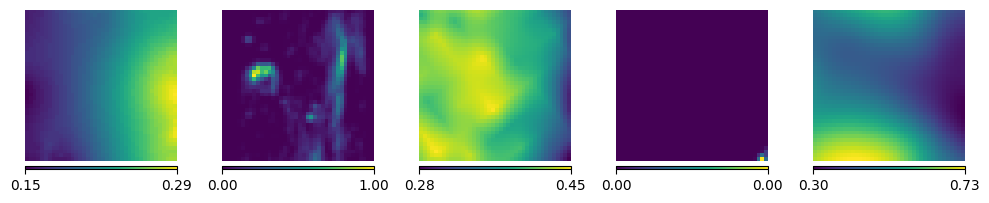

In [5]:
plot_sampled_images(true_maps, nb_columns=5, size=(10,5))

In [6]:
di = decim
dj = decim

# =============================================================================
# MIRIM MODEL
# =============================================================================

# reshape mirim model for the fusion model
mirim_model_for_fusion = Mirim_Model_For_Fusion(
    NIRCam_PSF, L_pce_mirim, lamb_cube, absolute_L_specs, shape_target, di, dj
)

# =============================================================================
# SPECTRO MODEL
# =============================================================================

# creation of spectro model from scratch
spectro_model = Spectro_Model_3(
    NIRSpec_PSF, L_pce_spectro, di, dj, lamb_cube, absolute_L_specs, shape_target
)

print(dottest(spectro_model))
print(fwadjtest(spectro_model))

True
False


In [7]:
L_snr = 60
snr_poisson = 150
print(f"SNR = {L_snr}")

# y_imager, L_std_mirim = noise_data.make_obs_data_with_snr(mirim_model_for_fusion, true_maps, L_snr[0])
# y_spectro, L_std_spectro = noise_data.make_obs_data_with_snr(spectro_model, true_maps, L_snr[0])


ms_poisson, gain = make_poisson_bandwise(mirim_model_for_fusion.forward(true_maps), snr_poisson)
y_imager, L_std_mirim = make_image_with_snr_gaussian(ms_poisson, L_snr)

hs_poisson, gain = make_poisson_bandwise(spectro_model.forward(true_maps), snr_poisson)
y_spectro, L_std_spectro = make_image_with_snr_gaussian(hs_poisson, L_snr)

mu_imager = mu_instru(L_std_mirim)
mu_spectro = mu_instru(L_std_spectro)

print("y_imager.shape = {}".format(y_imager.shape))
print("y_spectro.shape = {}".format(y_spectro.shape))

SNR = 60
y_imager.shape = (28, 40, 40)
y_spectro.shape = (1106, 20, 20)


In [8]:
MQM = Maps_Quality_Metrics_2(true_maps, absolute_L_specs)



# mirim_model_for_fusion = Mirim_Model_For_Fusion(
#     NIRCam_PSF, L_pce_mirim, lamb_cube, lmm_specs, shape_target, di, dj
# )

# spectro_model = Spectro_Model_3(
#     NIRSpec_PSF, L_pce_spectro, di, dj, lamb_cube, lmm_specs, shape_target
# )

In [9]:
#%% search for optimal reg parameter (mu) wrt best mse

quadcriterion_test = QuadCriterion2(
    mu_imager,
    y_imager,
    mirim_model_for_fusion,
    mu_spectro,
    y_spectro,
    spectro_model,
    0,
    printing = False,
    gradient = "separated"
)

# initial range of search
list_of_mu = [100, 500]
best_mse, best_mu = optimal_res_dicho_quad2(quadcriterion_test, MQM.get_mse, list_of_mu)

# for snr 50 :
# best_mse, best_mu = 0.02156771921471, 201.5625

[100, 200.0, 300.0, 400.0, 500]
Itération n°1
L_metric [11.098409945861183, 8.02426372083659, 6.528977556078377, 5.617454052024282, 4.993736215187033]
index_of_best_metric 4
new_list_of_mu : [400.0, 450.0, 500, 2750.0, 5000]
threshold 5.0
new_list_of_mu[0] - new_list_of_mu[-1] 4600.0


Itération n°2
L_metric [5.617454052024282, 5.279403326066451, 4.993736215187033, 2.118313526189889, 1.6397384158106854]
index_of_best_metric 4
new_list_of_mu : [2750.0, 3875.0, 5000, 27500.0, 50000]
threshold 50.0
new_list_of_mu[0] - new_list_of_mu[-1] 47250.0


Itération n°3
L_metric [2.118313526189889, 1.8222384873467172, 1.6397384158106854, 0.8694841869473375, 0.6892471606058842]
index_of_best_metric 4
new_list_of_mu : [27500.0, 38750.0, 50000, 275000.0, 500000]
threshold 500.0
new_list_of_mu[0] - new_list_of_mu[-1] 472500.0


Itération n°4
L_metric [0.8694841869473375, 0.7624044057204746, 0.6892471606058842, 0.3329879265592468, 0.2562181291334171]
index_of_best_metric 4
new_list_of_mu : [275000.0, 38

In [10]:
# when with unmixed spectra
# best_mu = 0.0025405273437499997

# when with unmixed GT spectra
# best_mu = 0.4234375

# when with true GT spectra
# best_mu = 487.5

#%% run solution with the best mu

quadcriterion = QuadCriterion2(
    mu_imager,
    y_imager,
    mirim_model_for_fusion,
    mu_spectro,
    y_spectro,
    spectro_model,
    best_mu,
    printing = False,
    gradient = "separated"
)

In [11]:
minimization = "iterative" # like Guilloteau et al. (2020)
# minimization = "iterative_with_metric" # add perf_crit argument to have access to a chosen metric wrt iterations

t1 = time.time()
if minimization == "explicit" :
    quadcrit_rec_maps = quadcriterion.run_expsol()
elif minimization == "iterative" :
    res = quadcriterion.run_lcg(maximum_iterations = 1000)
    quadcrit_rec_maps = res.x
elif minimization == "iterative_with_metric" :
    res = quadcriterion.run_lcg(maximum_iterations = 1000, perf_crit = MQM.get_psnr)
    quadcrit_rec_maps = res.x
    
    plt.plot(quadcriterion.L_perf_crit)
    plt.yscale("log")
print("Time = ", time.time() - t1)

# compare map recontructions
# plot_tools.plot_maps(true_maps, quadcrit_rec_maps)
print("MSE", MQM.get_mse(quadcrit_rec_maps))
print("PSNR", MQM.get_psnr(quadcrit_rec_maps))
print("SSIM", MQM.get_ssim(quadcrit_rec_maps))
print("SAM", MQM.get_sam(quadcrit_rec_maps))

guilloteau_fused = return_mixture(absolute_L_specs, quadcrit_rec_maps.T)[:, margin//2:-margin//2, margin//2:-margin//2]
y_imager = y_imager[:, margin//2:-margin//2, margin//2:-margin//2]
y_spectro = y_spectro[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]

Time =  1.4623775482177734
MSE 0.04388974761316911
PSNR 49.57066306131164
SSIM 0.9935574763116309
SAM 0.017648397989091204


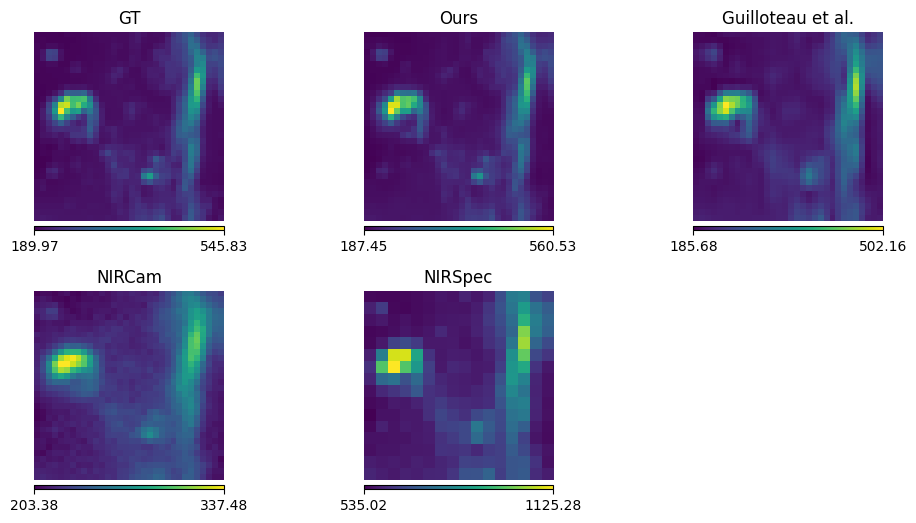

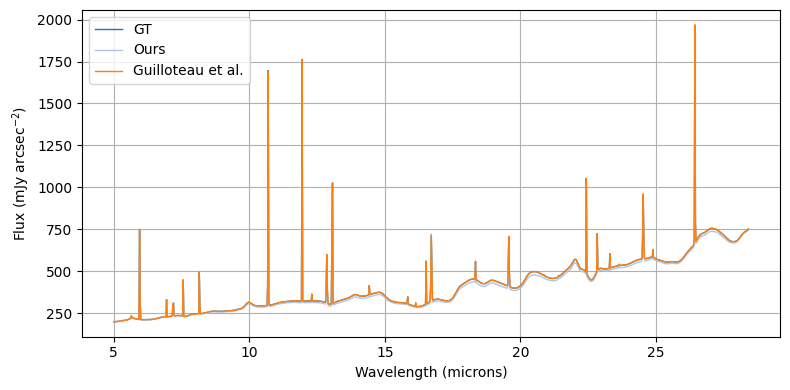

,Ours,Guilloteau et al.
Metric,,
NORM RMSE,0.005,0.040
PSNR,46.495,45.668
SAM,0.032,0.017
SSI,0.962,0.933


In [12]:
b_HS, b_MS = 100, 0
plot_sampled_images([GT[b_HS], AI_fused[b_HS], guilloteau_fused[b_HS], y_imager[b_MS], y_spectro[b_HS]], filters=["GT", "Ours", "Guilloteau et al.", "NIRCam", "NIRSpec"], nb_columns=3, size=(10,8))
plot_spec([GT.mean(axis=(1,2)), AI_fused.mean(axis=(1,2)), guilloteau_fused.mean(axis=(1,2))], filters=["GT", "Ours", "Guilloteau et al."])


pred_normed_RMSE, GT_normed_RMSE = norm_relative_ratio(AI_fused,GT)
RMSE = return_RMSE(GT_normed_RMSE, pred_normed_RMSE)
PSNR = calculate_psnr(AI_fused, GT, max_value=AI_fused.max())
SAM = compute_sam(GT, AI_fused).mean()
SSI = calculate_ssim(GT, AI_fused)

pred_normed_RMSE, GT_normed_RMSE = norm_relative_ratio(guilloteau_fused,GT)
RMSE_G = return_RMSE(GT_normed_RMSE, pred_normed_RMSE)
PSNR_G = calculate_psnr(guilloteau_fused, GT, max_value=guilloteau_fused.max())
SAM_G = compute_sam(GT, guilloteau_fused).mean()
SSI_G = calculate_ssim(GT, guilloteau_fused)

data = {
    'Metric': ['NORM RMSE', 'PSNR', 'SAM', 'SSI'],
    'Ours': [f"{RMSE:.3f}", f"{PSNR:.3f}", f"{SAM:.3f}", f"{SSI:.3f}"],
    'Guilloteau et al.': [f"{RMSE_G:.3f}", f"{PSNR_G:.3f}", f"{SAM_G:.3f}", f"{SSI_G:.3f}"]
}

# Create and display the DataFrame
df = pd.DataFrame(data)
df.set_index('Metric', inplace=True)
df

In [26]:
#  increasing values of maps so that the Huber function works as expected
mult_factor = 100
true_maps_100 = true_maps * mult_factor

y_imager_100, L_std_mirim = noise_data.make_obs_data_with_snr(mirim_model_for_fusion, true_maps_100, L_snr[0])
y_spectro_100, L_std_spectro = noise_data.make_obs_data_with_snr(spectro_model, true_maps_100, L_snr[0])

mu_imager = mu_instru(L_std_mirim)
mu_spectro = mu_instru(L_std_spectro)

MQM_100 = Maps_Quality_Metrics_2(true_maps_100, L_specs)

In [27]:
list_of_mu = [0.02, 0.15]

scale = 0.5
n_iter_max_crit = 1000
L_thresh = [0, 1, 2, 3]
L_best_mu = []
L_best_mse = []
for t in L_thresh:
    print("t", t)
    sq_criterion_test = SemiQuad_Criterion_Fusion(
        mu_imager,
        y_imager_100,
        mirim_model_for_fusion,
        mu_spectro,
        y_spectro_100,
        spectro_model,
        mu_reg = 0,
        thresh = t,
        printing = False,
        scale = scale
    )
    
    best_mse, best_mu = optimal_res_dicho_semiquad2(sq_criterion_test,
                                                                    MQM_100.get_mse,
                                                                    list_of_mu,
                                                                    printing=True,
                                                                    max_iter=30,
                                                                    tolerance=0.01,
                                                                    n_iter_max_crit=n_iter_max_crit,
                                                                    diff_min=1e-20)
    L_best_mu.append(best_mu)
    L_best_mse.append(best_mse)

print(L_thresh)
print(L_best_mu)
print(L_best_mse)

t 0
Huber threshold = 0
Parameter scale = 0.5


[0.02, 0.0525, 0.08499999999999999, 0.1175, 0.15]
Itération n°1
L_metric [0.006991252628814907, 0.006004332444495505, 0.005976654558540595, 0.0060984014172606755, 0.006255816716282822]
index_of_best_metric 2
new_list_of_mu : [0.0525, 0.06874999999999999, 0.08499999999999999, 0.10124999999999999, 0.1175]
threshold 0.00085
new_list_of_mu[0] - new_list_of_mu[-1] 0.065


Itération n°2
L_metric [0.006004332444495505, 0.005955427202869611, 0.005976654558540595, 0.006029655988340531, 0.0060984014172606755]
index_of_best_metric 1
new_list_of_mu : [0.0525, 0.060625, 0.06874999999999999, 0.076875, 0.08499999999999999]
threshold 0.0006875
new_list_of_mu[0] - new_list_of_mu[-1] 0.032499999999999994


Itération n°3
L_metric [0.006004332444495505, 0.005967021224829274, 0.005955427202869611, 0.005960478552556934, 0.005976654558540595]
index_of_best_metric 2
new_list_of_mu : [0.060625, 0.0646875, 0.06874999999999999, 0.0728125, 0.076875]
threshold 0.0006

In [28]:
best_thresh = 1
# best_mu = 0.057197265625

#%%

# check courbe de MSE

sq_criterion = SemiQuad_Criterion_Fusion(
    mu_imager,
    y_imager_100,
    mirim_model_for_fusion,
    mu_spectro,
    y_spectro_100,
    spectro_model,
    mu_reg = best_mu,
    thresh = best_thresh,
    printing = True,
    scale = 0.5
)

minimization = "iterative"
# minimization = "iterative_with_metric"

t1 = time.time()
if minimization == "iterative" :
    rec_maps_sq = sq_criterion.run_expsol(n_iter_max = 2000, diff_min = 1e-25, calc_crit = False)
elif minimization == "iterative_with_metric" :
    rec_maps_sq = sq_criterion.run_expsol(n_iter_max = 2000, diff_min = 1e-25, calc_crit = False, perf_crit = MQM_100.get_psnr)
    
    L_mse_sq = sq_criterion.L_perf_crit
    plt.plot(L_mse_sq)
    
print(time.time() - t1)


# compare map recontructions
# plot_tools.plot_maps(true_maps, rec_maps_sq)
print("MSE", MQM_100.get_mse(rec_maps_sq))
print("PSNR", MQM_100.get_psnr(rec_maps_sq))
print("SSIM", MQM_100.get_ssim(rec_maps_sq))
print("SAM", MQM_100.get_sam(rec_maps_sq))

Huber threshold = 1
Parameter scale = 0.5


iteration 200, diff = 0.2613810184000296
iteration 400, diff = 0.5246420926950175
iteration 600, diff = 0.13187687533433878
iteration 800, diff = 0.08497067211289537
iteration 1000, diff = 0.03407088110881051
iteration 1200, diff = 0.013287982857386952
iteration 1400, diff = 0.005300430205032262
iteration 1600, diff = 0.0028486222569764816
iteration 1800, diff = 0.0013313311556707199
iteration 2000, diff = 0.0006856169677927835
Reconstruction ended
Number of executed iterations : 2000 (2.665 sec)
Total time needed = 0.236 + 2.665 = 2.901 sec.
Iterations ended due to :
Maximum number of iterations reached. Convergence not ensured.


2.901829242706299
MSE 0.004308424152582891
PSNR 57.7169320033009
SSIM 0.9987517886667386
SAM 0.0012466086804595559


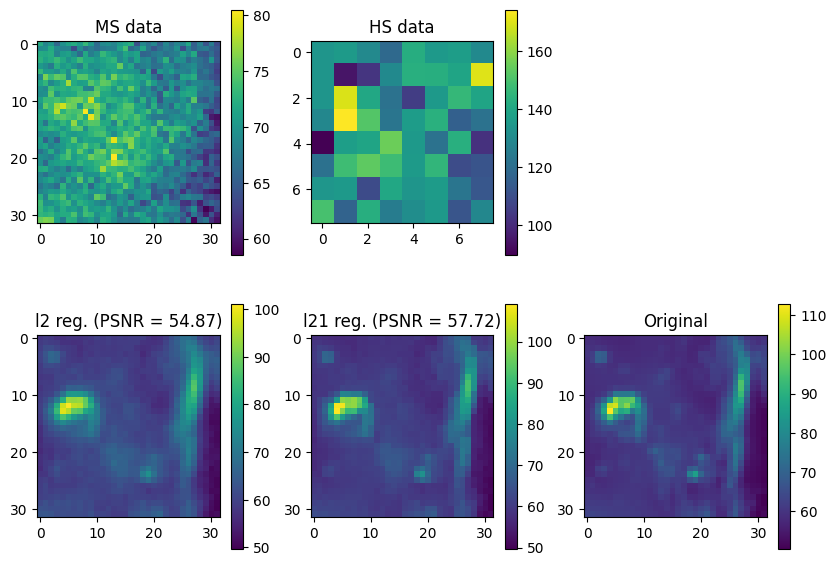

In [29]:
new_origin = (4, 4)
new_size_i = 32
new_size_j = 32

l2_cube = plot_tools.maps_to_cube(quadcrit_rec_maps, L_specs)[:, new_origin[0] : new_origin[0] + new_size_i, new_origin[1] : new_origin[1] + new_size_j]
l21_cube = plot_tools.maps_to_cube(rec_maps_sq, L_specs)[:, new_origin[0] : new_origin[0] + new_size_i, new_origin[1] : new_origin[1] + new_size_j] / mult_factor
true_cube = plot_tools.maps_to_cube(true_maps, L_specs)[:, new_origin[0] : new_origin[0] + new_size_i, new_origin[1] : new_origin[1] + new_size_j]

#%% save cubes

# name_file = "l2_cube"
# saver.save_numpy_file(name_file, l2_cube)

# name_file = "l21_cube"
# saver.save_numpy_file(name_file, l21_cube)

# name_file = "true_cube"
# saver.save_numpy_file(name_file, true_cube)

#%% compare reconstructions

# chosen wavelength
lamb = 120

fig = plt.figure(figsize=(10,7))

n_rows, n_cols = 2, 3
i = 1

plt.subplot(n_rows, n_cols, i)
plt.imshow(y_imager[8, new_origin[0] : new_origin[0] + new_size_i, new_origin[1] : new_origin[1] + new_size_j])
plt.colorbar()
plt.title("MS data")

i += 1
plt.subplot(n_rows, n_cols, i)
plt.imshow(y_spectro[lamb, new_origin[0] // di : new_origin[0] // di + new_size_i // di, new_origin[1] // dj : new_origin[1] // dj + new_size_j // dj])
plt.colorbar()
plt.title("HS data")

i += 1
i += 1
plt.subplot(n_rows, n_cols, i)
plt.imshow(l2_cube[lamb])
plt.colorbar()
plt.title(f"l2 reg. (PSNR = {round(MQM.get_psnr(quadcrit_rec_maps), 2)})")

i += 1
plt.subplot(n_rows, n_cols, i)
plt.imshow(l21_cube[lamb])
plt.colorbar()
plt.title(f"l21 reg. (PSNR = {round(MQM_100.get_psnr(rec_maps_sq), 2)})")

i += 1
plt.subplot(n_rows, n_cols, i)
plt.imshow(true_cube[lamb])
plt.colorbar()
plt.title("Original")
plt.show()

#%% save figure

# name_file = "comp_rec"
# saver.save_figure(name_file, fig)